In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from highlight_text import ax_text, fig_text
from drawarrow import ax_arrow

In [2]:
df1 = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-06-17/api_categories.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-06-17/api_info.csv')
df3 = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-06-17/api_logos.csv')
df4 = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-06-17/api_origins.csv')
df5 = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-06-17/apisguru_apis.csv')

In [3]:
df1.head(1)

,name,apisguru_category
0,1forge.com,financial


In [4]:
df2.head(1)

,name,contact_name,contact_url,description,title,provider_name,service_name,license_name,license_url,terms_of_service
0,1forge.com,1Forge,http://1forge.com,Stock and Forex Data and Realtime Quotes,1Forge Finance APIs,1forge.com,NaN,NaN,NaN,NaN


In [5]:
df3.head(1)

,name,background_color,url,alt_text
0,1forge.com,#24292e,https://api.apis.guru/v2/cache/logo/https_1for...,NaN


In [6]:
df4.head(1)

,name,format,url,version
0,1forge.com,swagger,http://1forge.com/openapi.json,2.0


In [7]:
df5.head(1)

,name,version,added,updated,swagger_url,openapi_ver,link,external_docs_description,external_docs_url
0,1forge.com,0.0.1,2017-05-30T08:34:14Z,2017-06-27T16:49:57Z,https://api.apis.guru/v2/specs/1forge.com/0.0....,2.0,https://api.apis.guru/v2/specs/1forge.com/0.0....,NaN,NaN


In [8]:
df5["year"] = pd.to_datetime(df5["added"]).dt.year

In [9]:
df5["date"] = pd.to_datetime(df5["added"]).dt.date

In [10]:
df5 = df5[["name", "year", "date"]]

In [11]:
dfm = pd.merge(df5, df4, on="name")

In [12]:
dfm = dfm.drop(columns="url")

In [13]:
df = pd.merge(dfm, df1, on="name")

In [14]:
df["apisguru_category"] = df["apisguru_category"].str.replace("_", " ")

In [15]:
df["format"] = df["format"].fillna("other")
df["apisguru_category"] = df["apisguru_category"].fillna("other")

In [16]:
df["date"] = pd.to_datetime(df["date"])

In [17]:
df = df.sort_values(by="date")

In [18]:
df["format"].value_counts()

format
swagger         1029
openapi          965
google           502
other            273
postman           14
wadl               5
apiBlueprint       3
Name: count, dtype: int64

In [19]:
other_formats = ["postman", "wadl", "apiBlueprint"]
df.loc[df["format"].isin(other_formats), "format"] = "other"

In [20]:
df_count = df.groupby(["year", "format"])["format"].value_counts().reset_index(name="count")

In [21]:
df_count.head(2)

,year,format,count
0,2015,google,2
1,2015,openapi,23


In [22]:
pivot_df = df_count.pivot_table(index='year', columns='format', values='count', sort=False)

In [23]:
pivot_df = pivot_df.fillna(0)

In [24]:
pivot_df.head(2)

format,google,openapi,swagger,other
year,,,,
2015,2.0,23.0,54.0,0.0
2016,0.0,35.0,43.0,0.0


In [25]:
df_grouped=df.groupby(["format", "apisguru_category"])["apisguru_category"].value_counts().reset_index(name="count").sort_values(by=["format", "count"], ascending=[True, False]) 

In [26]:
google = df_grouped[df_grouped["format"] == "google"]
google_cat = google["apisguru_category"].value_counts().sum()
google_total = google["count"].sum()
google = google.copy()
google["percent"] = (google["count"] / google_total)*100
google.head(1)

,format,apisguru_category,count,percent
0,google,analytics,250,49.800797


In [27]:
openapi = df_grouped[df_grouped["format"] == "openapi"]
openapi_cat = openapi["apisguru_category"].value_counts().sum()
openapi_total = openapi["count"].sum()
openapi = openapi.copy()
openapi["percent"] = (openapi["count"] / openapi_total)*100
openapi.head(1)

,format,apisguru_category,count,percent
28,openapi,open data,266,27.564767


In [28]:
swagger = df_grouped[df_grouped["format"] == "swagger"]
swagger_cat = swagger["apisguru_category"].value_counts().sum()
swagger_total = swagger["count"].sum()
swagger = swagger.copy()
swagger["percent"] = (swagger["count"] / swagger_total)*100
swagger.head(1)

,format,apisguru_category,count,percent
59,swagger,cloud,671,65.208941


In [29]:
other = df_grouped[df_grouped["format"] == "other"]
other_cat = other["apisguru_category"].value_counts().sum()
other_total = other["count"].sum()
other = other.copy()
other["percent"] = (other["count"] / other_total)*100
other.head(1)

,format,apisguru_category,count,percent
46,other,cloud,271,91.864407


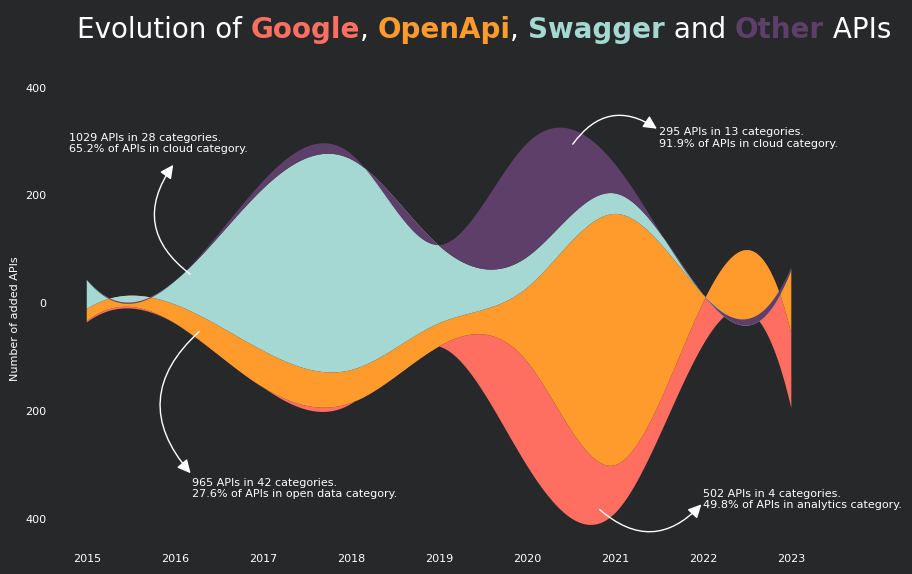

In [45]:
colors = ["#FF6F61", "#FF9A2C", "#A6D8D3", "#5D3F6A"]

x_smooth = np.linspace(pivot_df.index.min(), pivot_df.index.max(), 100)
pivot_smooth = pd.DataFrame({format: make_interp_spline(pivot_df.index, pivot_df[format])(x_smooth)
                             for format in pivot_df.columns})

fig, ax = plt.subplots(figsize=(10, 6))  
ax.stackplot(x_smooth,
              pivot_smooth.values.T,
              colors=colors,              
              baseline='wiggle')              

ax.set_ylabel('Number of added APIs', color="white", size=8) 

ax_arrow(
  [2016.2, 50],
  [2016, 260],
  color="white",
  radius=-0.5
)

ax.text(2014.8, 280, s=f'{swagger_total} APIs in {swagger_cat} categories.\n{swagger.iloc[0, -1]:.1f}% of APIs in {swagger.iloc[0, 1]} category.',
       size=8, color="white")

ax_arrow(
  [2020.5, 290],
  [2021.5, 320],
  color="white",
  radius=-0.5
)

ax.text(2021.5, 290, s=f'{other_total} APIs in {other_cat} categories.\n{other.iloc[0, -1]:.1f}% of APIs in {other.iloc[0, 1]} category.',
       size=8, color="white")

ax_arrow(
  [2016.3, -50],
  [2016.2, -320],
  color="white",
  radius=0.5
)

ax.text(2016.2, -360, s=f'{openapi_total} APIs in {openapi_cat} categories.\n{openapi.iloc[0, -1]:.1f}% of APIs in {openapi.iloc[0, 1]} category.',
       size=8, color="white")

ax_arrow(
  [2020.8, -380],
  [2022, -370],
  color="white",
  radius=0.5
)

ax.text(2022, -380, s=f'{google_total} APIs in {google_cat} categories.\n{google.iloc[0, -1]:.1f}% of APIs in {google.iloc[0, 1]} category.',
       size=8, color="white")

location = [-400, -200, 0, 200, 400]
labels = ["400", "200", "0", "200", "400"]
ax.set_yticks(location, labels=labels)

ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
ax.tick_params(length=0)

ax.tick_params(axis="both", labelsize=8, labelcolor="white")

ax.set_facecolor("#26282A") 
fig.set_facecolor("#26282A")  

fig_text(
    x=0.15, y=1,
    s="Evolution of <Google>, <OpenApi>, <Swagger> and <Other> APIs",
    color="white",
    ax=ax, size=20,
    highlight_textprops=[
        {"color": colors[0], "weight": "bold"},
        {"color": colors[1], "weight": "bold"},
        {"color": colors[2], "weight": "bold"},
        {"color": colors[3], "weight": "bold"},
  ])

fig.text(0.15, 0.05, "Data: TidyTuesday 2025-06-17 (API Specs) | Design: Bernadett Piros",
         size=8, color="white")

#plt.show()

fig.savefig("2025-06-17.png", bbox_inches='tight', pad_inches=0.2)